## Modeling Project - Experiment 2

In [14]:
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import arviz as az
import hssm
import hssm.plotting
hssm.set_floatX("float32")

Setting PyTensor floatX type to float32.
Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


## Preprocessing of the collected data

In [15]:
# Initialize empty list 
dfs = []
participant_ids = []

# Iterate through each CSV file in the folder
pathlist = Path("data/").rglob('*.csv')
for participant_id, path in enumerate(pathlist, start=1):
    df = pd.read_csv(path)
    dfs.append(df)
    participant_ids.extend([participant_id] * len(df))

# Concatenate all DataFrames in the list into one DataFrame
combined_df = pd.concat(dfs, ignore_index=True)
combined_df['participant_id'] = participant_ids
#print(combined_df)

# Reorder columns to place participant ID column first
cols = combined_df.columns.tolist()
cols = ['participant_id'] + [col for col in cols if col != 'participant_id']
combined_df = combined_df[cols]

# Clean data
combined_df = combined_df.dropna()
combined_df = combined_df[combined_df.rt != -1]

true_false_lst_mov = []
true_false_lst_or = []

# Iterate through each task type
for task_type in combined_df['task_type'].unique():
    # Filter the DataFrame for the current task type
    task_data = combined_df[combined_df['task_type'] == task_type]
    
    # Iterate through each participant
    for i in range(1, max(task_data['participant_id']) + 1):
        # Filter the DataFrame for the current participant and task type
        participant_data = task_data[(task_data['participant_id'] == i)]
        
        # Count the True and False answers for the current participant
        true_count = participant_data['correct'].eq(True).sum()
        false_count = participant_data['correct'].eq(False).sum()
        total_count = true_count + false_count
        
        # Calculate ratio
        if total_count > 0:
            ratio_count = true_count / total_count
        else:
            ratio_count = 0.0
        
        # Create a dictionary with the counts for the current participant and task type
        bool_dict = {
            "Participant": i,
            "Task_Type": task_type,
            "True": true_count,
            "False": false_count,
            "ratio": ratio_count
        }
        
        # Append the dictionary to respective list based on task type
        if task_type == 'mov':
            true_false_lst_mov.append(bool_dict)
        elif task_type == 'or':
            true_false_lst_or.append(bool_dict)


# Get the intersection of the two lists to find participants meeting both conditions
selected_ids_mov = [x['Participant'] for x in true_false_lst_mov if x['ratio'] >= 0.8]
selected_ids_or = [x['Participant'] for x in true_false_lst_or if x['ratio'] >= 0.8]
selected_ids = list(set(selected_ids_mov).intersection(selected_ids_or))

# Filter the combined_df based on the selected_participant_ids
filtered_df = combined_df[combined_df.participant_id.isin(selected_ids)]

# extra df for plots
df_repetition = filtered_df[filtered_df['task_transition'] == 'repetition']
df_switch = filtered_df[filtered_df['task_transition'] == 'switch']
df_or = filtered_df[filtered_df.task_type == "or"]
df_mov = filtered_df[filtered_df.task_type == "mov"]

#filtered_df

#combined_df
#for entry in true_false_lst:
#    print(entry)
#for entry in true_false_lst_mov:
#    print(entry)
#for entry in true_false_lst_or:
#    print(entry)
#len(selected_ids)

filtered_df_m = filtered_df
# coding the task transition 0: repetition; 1: switch
filtered_df_m['task_transition'] = filtered_df_m['task_transition'].replace({'repetition': 0, 'switch': 1})

#renaming the "correct" column to "response"
filtered_df_m = filtered_df_m.rename(columns={'correct': 'response'})
#replacing the boolena values True and False with 1 and -1
filtered_df_m['response'] = filtered_df_m['response'].replace({True: 1, False: -1})

filtered_df_m['rt'] = filtered_df_m['rt']/1000

        
print(filtered_df_m.head())


     participant_id     rt key_press  response  coherent_movement_direction  \
97                2  0.547         f         1                          180   
98                2  1.101         f         1                            0   
99                2  0.745         f         1                          180   
100               2  0.943         f         1                          180   
101               2  0.814         f         1                          180   

     coherent_orientation task_type  task_transition   congruency  
97                    180       mov                0    congruent  
98                    180        or                1  incongruent  
99                      0       mov                1  incongruent  
100                   180        or                1    congruent  
101                   180        or                0    congruent  


/var/folders/fb/kw7tlmbd0395bss45ptbvfwm0000gn/T/ipykernel_22246/2873953622.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_m['task_transition'] = filtered_df_m['task_transition'].replace({'repetition': 0, 'switch': 1})


In [16]:
"""
Getting total True_False answers
"""
"""
# Iterate through each participant
for i in range(1, max(combined_df.participant_id) + 1):
    # Filter the DataFrame for the current participant
    participant_data = combined_df[combined_df.participant_id == i]
    
    # Count the True and False answers for the current participant and its ratio
    true_count = participant_data['correct'].eq(True).sum()
    false_count = participant_data['correct'].eq(False).sum()
    ratio_count = true_count / (true_count + false_count) 
    
    # Create a dictionary with the counts
    bool_dict_total = {
        "Participant": i,
        "True": true_count,
        "False": false_count,
        "ratio": ratio_count
    }
    
    # Append the dictionary to the list
    true_false_lst.append(bool_dict)

"""

'\n# Iterate through each participant\nfor i in range(1, max(combined_df.participant_id) + 1):\n    # Filter the DataFrame for the current participant\n    participant_data = combined_df[combined_df.participant_id == i]\n    \n    # Count the True and False answers for the current participant and its ratio\n    true_count = participant_data[\'correct\'].eq(True).sum()\n    false_count = participant_data[\'correct\'].eq(False).sum()\n    ratio_count = true_count / (true_count + false_count) \n    \n    # Create a dictionary with the counts\n    bool_dict_total = {\n        "Participant": i,\n        "True": true_count,\n        "False": false_count,\n        "ratio": ratio_count\n    }\n    \n    # Append the dictionary to the list\n    true_false_lst.append(bool_dict)\n\n'

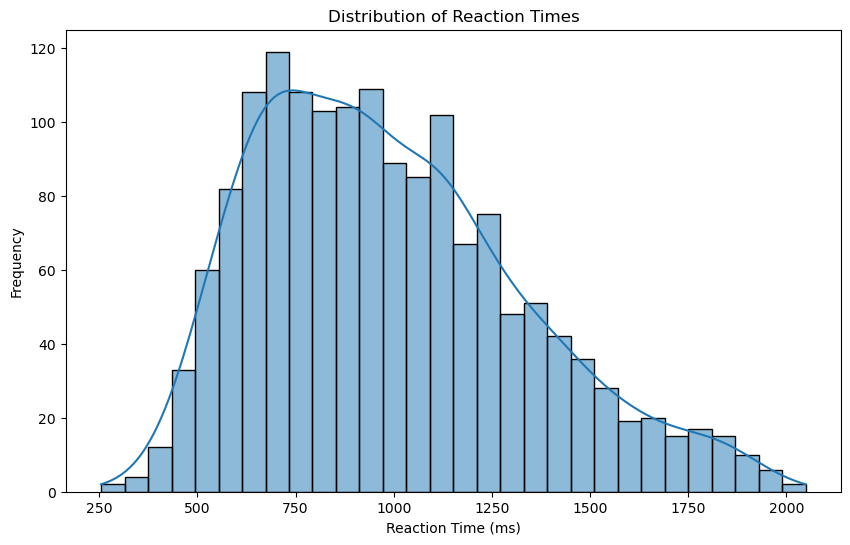

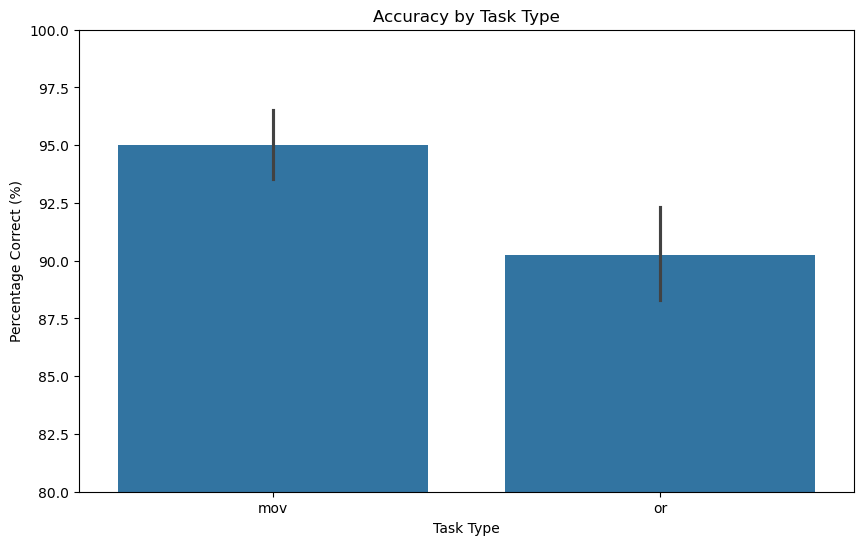

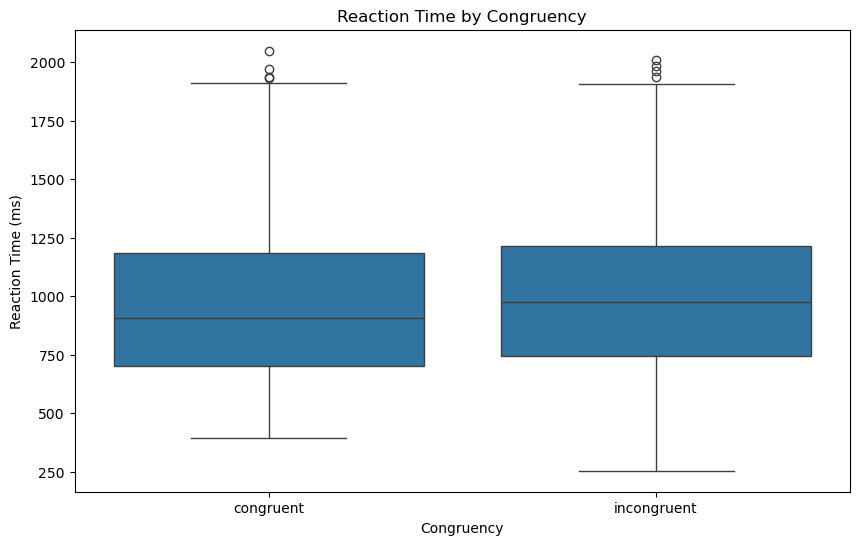

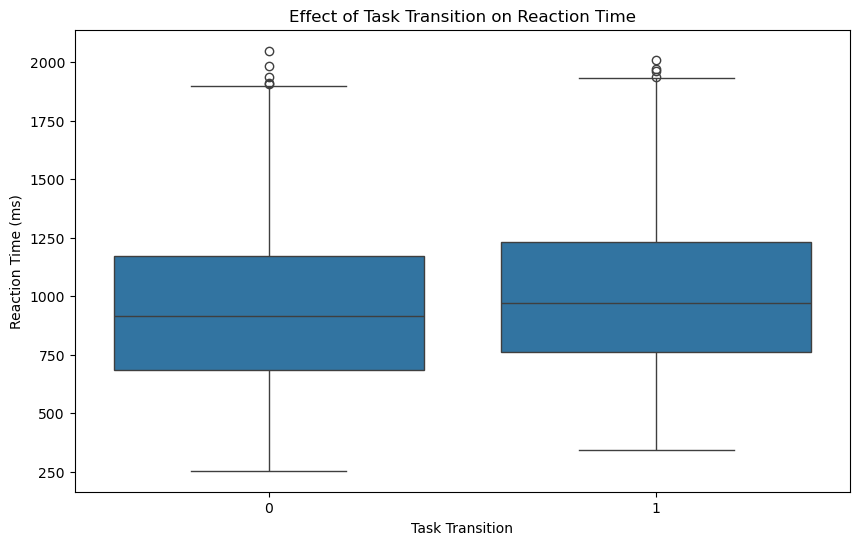

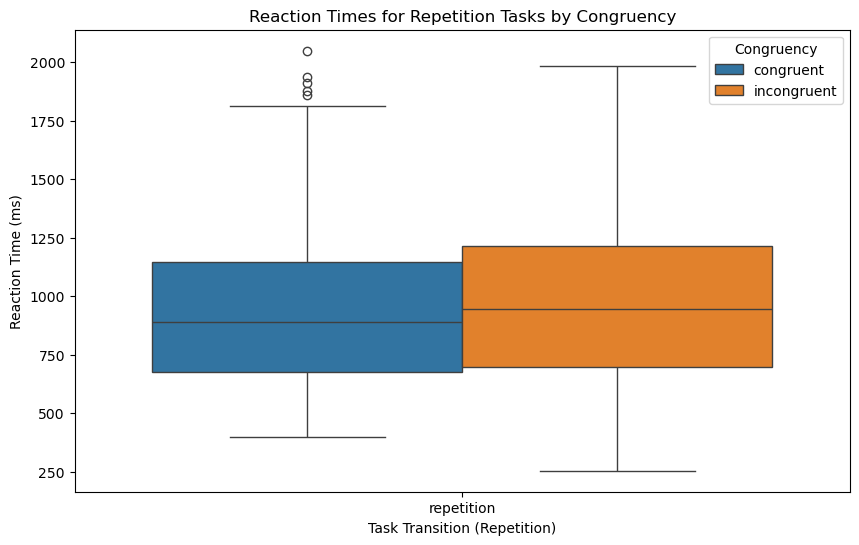

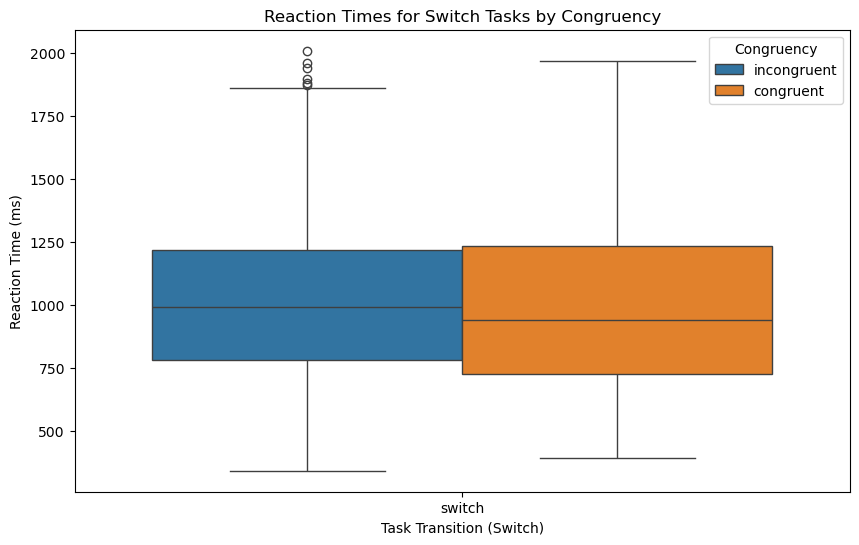

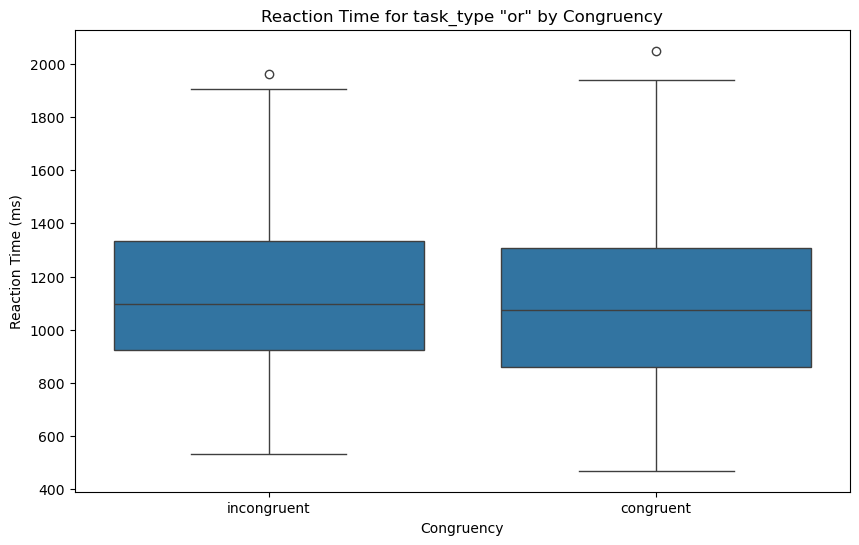

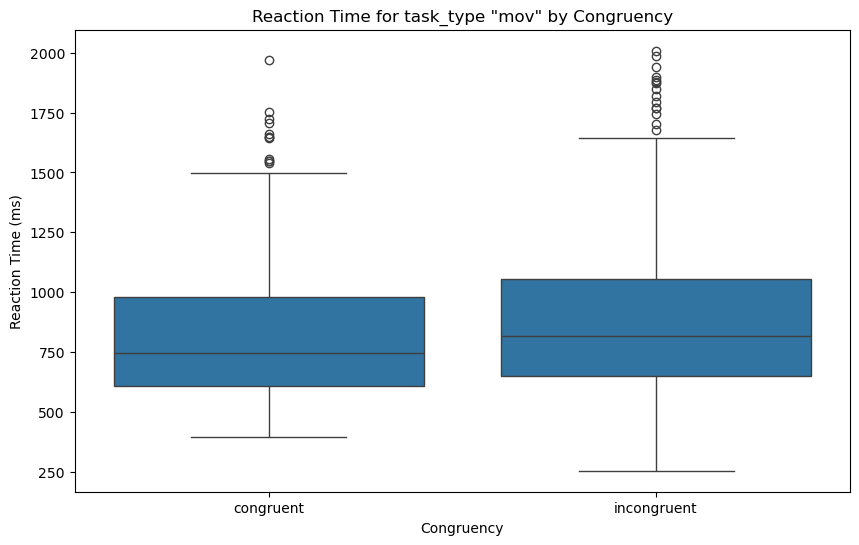

In [17]:
# Visualization 1: Distribution of Reaction Times
plt.figure(figsize=(10, 6))
sns.histplot(data=filtered_df, x="rt", kde=True, bins=30)
plt.title('Distribution of Reaction Times')
plt.xlabel('Reaction Time (ms)')
plt.ylabel('Frequency')
plt.show()

# Visualization 2: Accuracy by Task Type
plt.figure(figsize=(10, 6))
sns.barplot(x="task_type", y="correct", data=filtered_df, estimator=lambda x: sum(x.astype(int)) / len(x) * 100)
plt.title('Accuracy by Task Type')
plt.xlabel('Task Type')
plt.ylabel('Percentage Correct (%)')
plt.ylim(80, 100)
plt.show()

# Visualization 3: Reaction Time by Congruency
plt.figure(figsize=(10, 6))
sns.boxplot(x="congruency", y="rt", data=filtered_df)
plt.title('Reaction Time by Congruency')
plt.xlabel('Congruency')
plt.ylabel('Reaction Time (ms)')
plt.show()

# Visualization 4: Task Transition Effects on Reaction Time
plt.figure(figsize=(10, 6))
sns.boxplot(x="task_transition", y="rt", data=filtered_df)
plt.title('Effect of Task Transition on Reaction Time')
plt.xlabel('Task Transition')
plt.ylabel('Reaction Time (ms)')
plt.show()

# Visualization 5: Reaction Times for Repetition Tasks by Congruency
plt.figure(figsize=(10, 6))
sns.boxplot(x="task_transition", y="rt", hue="congruency", data=df_repetition)
plt.title('Reaction Times for Repetition Tasks by Congruency')
plt.xlabel('Task Transition (Repetition)')
plt.ylabel('Reaction Time (ms)')
plt.legend(title='Congruency')
plt.show()

# Visualization 6: Reaction Times for Switch Tasks by Congruency
plt.figure(figsize=(10, 6))
sns.boxplot(x="task_transition", y="rt", hue="congruency", data=df_switch)
plt.title('Reaction Times for Switch Tasks by Congruency')
plt.xlabel('Task Transition (Switch)')
plt.ylabel('Reaction Time (ms)')
plt.legend(title='Congruency')
plt.show()

# Visualization 7: Reaction Time for task_type "or" by Congruency
plt.figure(figsize=(10, 6))
sns.boxplot(x="congruency", y="rt", data=df_or)
plt.title('Reaction Time for task_type "or" by Congruency')
plt.xlabel('Congruency')
plt.ylabel('Reaction Time (ms)')
plt.show()

# Visualization 8: Reaction Time for task_type "mov" by Congruency
plt.figure(figsize=(10, 6))
sns.boxplot(x="congruency", y="rt", data=df_mov)
plt.title('Reaction Time for task_type "mov" by Congruency')
plt.xlabel('Congruency')
plt.ylabel('Reaction Time (ms)')
plt.show()



## Model Implementation *(3 points)*

For this exercise you should:

*   Implement and simulate data from two* models that are suitable to test your hypothesis. *(3 points)*

<font size=2>*You may implement more than two models if you wish. However, two models are sufficient for this group project.</font>

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


<br>

**Hypothesis:**

Participants are expected to react slower if the task switches vs. repeats.

• coherent movement direction: Stimulus movement direction (0: right; 180: left)

• coherent orientation direction: Stimulus orientation (0: right; 180: left)

• congruency: Alignment between orientation and movement (congruent: movement = orientation; incongruent: movement ̸= orientation).

<br>

We want to **explore whether the task transition has an effect on the drift rate or threshold**. 

This could be done by coding the task transition 0: repetition; 1: switch. 

One could then formulate a drift rate regression model, e.g describing the drift rate as follows:

_v_ 1 + task transition

This model would test if the task transition would have an influence on processing efficacy. Alternatively, we could examine whether the task transition has an influence on threshold:

_a_ 1 + task transition


## ...

In [18]:
def run_ddm(drift_rate = 1,
            threshold = 1,
            starting_point = 0.5,
            noise_std = 1,
            non_decision_time = 0,
            dt = 0.01,
            max_time = 200):
    """
    Simulates the Drift Diffusion Model for one run with fixed time increments to match evidence points.

    Parameters are the same as the previous function.

    Arguments:
    - drift_rate: rate of evidence accumulation
    - threshold: evidence needed to reach a decision
    - starting_point: initial condition of the evidence
    - noise_std: standard deviation of the noise term
    - non_decision_time: time not included in the evidence accumulation process
    - dt: time increment
    - max_time: maximum simulation time

    Returns:
    - decision_time: the time taken to reach a decision
    - evidence_over_time: the evidence accumulated over time
    - decision: 1 if the decision boundary reached is the upper threshold, -1 if lower
    """
    # Initialize evidence accumulation process
    time = non_decision_time
    evidence = starting_point
    evidence_over_time = [evidence]

    # Run the simulation until a decision boundary is reached or max time is exceeded
    while time < max_time:
        # Increment the evidence by the drift and some noise
        evidence += drift_rate * dt + np.sqrt(dt) * noise_std * np.random.normal() # THERE IS A BUG IN THIS LINE
        evidence_over_time.append(evidence)
        time += dt  # Increment the time

        # Check if the evidence has reached either threshold
        if evidence >= threshold: # THERE IS A BUG IN THIS LINE
            return time, evidence_over_time, 1  # Decision made for the upper threshold
        elif evidence <= 0:
            return time, evidence_over_time, -1  # Decision made for the lower threshold

    # If no decision has been made by max_time, return the current state
    return time, evidence_over_time, 0

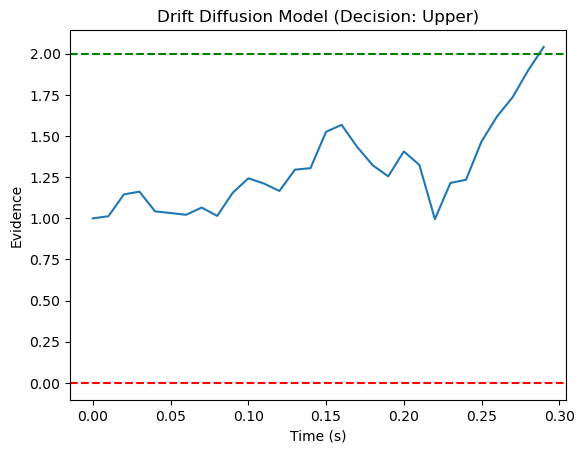

In [19]:
v = 0.01          # drift rate
a = 2             # threshold
z = a/2           # starting point (between 0 and threshold a)
sigma = 1         # standard deviation of noise
t0 = 0            # non-decision time
dt = 0.01         # integration constant
max_time = 1000   # maximum number of simulated seconds

# Run the simulation with the fixed function
decision_time, evidence_over_time, decision = run_ddm(drift_rate = v,
                                                      threshold = a,
                                                      starting_point = z,
                                                      noise_std = sigma,
                                                      non_decision_time = t0,
                                                      dt = dt,
                                                      max_time = max_time)

# Plot the results with the correct matching of time and evidence points
plt.plot(np.linspace(t0+0, t0+decision_time, len(evidence_over_time)), evidence_over_time)
plt.axhline(y=a, color='green', linestyle='--')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Evidence')
plt.title(f'Drift Diffusion Model (Decision: {"Upper" if decision == 1 else "Lower" if decision == 0 else "None"})')
plt.show()

## Implementation

In [35]:
varying_drift_model = hssm.HSSM(
    data=filtered_df_m,
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + task_transition"
        }
    ],
    a = 1.166
)

In [36]:
varying_threshold_model = hssm.HSSM(
    data=filtered_df_m,
    include=[
        {
            "name": "a",
            "formula": "a ~ 1 + task_transition"
        }  
    ],
    v = 0.557
)

In [31]:
v = 0.557             # drift rate
a = 1.166             # threshold
z = 0.75            # starting point (between 0 and threshold a)
t0 = 0            # non-decision time

true_values = [v, a, z, t0]

hssm_dataset = hssm.simulate_data(
    model="ddm",
    theta=true_values,
    size=500,
)

print(hssm_dataset)

           rt  response
0    2.351212       1.0
1    1.338112       1.0
2    0.992950       1.0
3    0.168015       1.0
4    0.111317       1.0
..        ...       ...
495  0.352777       1.0
496  0.106329       1.0
497  0.191583       1.0
498  0.968193       1.0
499  0.200540       1.0

[500 rows x 2 columns]


In [22]:
simulated_data_drift = varying_drift_model.sample()  # Adjust num_samples as needed

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_task_transition]


KeyboardInterrupt: 

In [37]:
simulated_data_threshold = varying_threshold_model.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Traceback (most recent call last):
  File "/Users/laurakinderknecht/anaconda3/envs/ml/lib/python3.11/multiprocessing/forkserver.py", line 274, in main
    code = _serve_one(child_r, fds,
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurakinderknecht/anaconda3/envs/ml/lib/python3.11/multiprocessing/forkserver.py", line 313, in _serve_one
    code = spawn._main(child_r, parent_sentinel)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurakinderknecht/anaconda3/envs/ml/lib/python3.11/multiprocessing/spawn.py", line 130, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
_pickle.UnpicklingError: pickle data was truncated


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'z_interval__': array(0., dtype=float32), 't_log__': array(-2.3025851, dtype=float32), 'a_Intercept': array(0., dtype=float32), 'a_task_transition': array(0., dtype=float32)}

Logp initial evaluation results:
{'z': -1.39, 't': -3.22, 'a_Intercept': -2.17, 'a_task_transition': -2.53, 'rt,response': inf}
You can call `model.debug()` for more details.

In [ ]:
print(simulated_data)

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data


In [ ]:
correct_model.plot_trace()

In [ ]:
az.summary(correct_model.traces)

In [ ]:
hssm.plotting.plot_posterior_predictive(correct_model)

In [ ]:
model_comparison = az.compare(
    {
        "correct": correct_model.traces,
        "wrong": wrong_model.traces,
    }
)

model_comparison

## Model Simulation *(3 points)*

For this exercise you should:

*   Simulate data from both models for a single set of parameters. The simulation should mimic the experiment you are trying to model. *(2 points)*

*   Plot the simulated behavior of both models. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


In [ ]:
def plot_ddm_histograms(rt_upper_simulated, rt_lower_simulated, rt_upper_empirical = None, rt_lower_empirical = None, y_max = 0.5):

  # Calculate the weights for each group to normalize the histograms
  weights_upper_simulated = np.ones_like(rt_upper_simulated) / float(len(rt_upper_simulated)+len(rt_lower_simulated))
  weights_lower_simulated = np.ones_like(rt_lower_simulated) / float(len(rt_upper_simulated)+len(rt_lower_simulated))

  if rt_upper_empirical is not None and rt_lower_empirical is not None:
    weights_upper_empirical = np.ones_like(rt_upper_empirical) / float(len(rt_upper_empirical)+len(rt_lower_empirical))
    weights_lower_empirical = np.ones_like(rt_lower_empirical) / float(len(rt_upper_empirical)+len(rt_lower_empirical))

  # set up figure
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

  # Plot the histograms for upper threshold
  axs[0].hist(rt_upper_simulated, bins=30, weights=weights_upper_simulated, alpha=0.5, color='blue', label='Simulated DDM')
  if rt_upper_empirical is not None:
    axs[0].hist(rt_upper_empirical, bins=30, weights=weights_upper_empirical, alpha=0.5, color='orange', label='Empirical Data')
  axs[0].set_xlabel('Reaction Time (s)')
  axs[0].set_ylabel('Normalized Frequency')
  axs[0].legend()
  axs[1].set_ylim([0, y_max])
  axs[0].set_title('Upper Threshold')

  # Plot the histograms for lower threshold
  axs[1].hist(rt_lower_simulated, bins=30, weights=weights_lower_simulated, alpha=0.5, color='blue', label='Simulated DDM')
  if rt_upper_empirical is not None:
    axs[1].hist(rt_lower_empirical, bins=30, weights=weights_lower_empirical, alpha=0.5, color='orange', label='Empirical Data')
  axs[1].set_xlabel('Reaction Time (s)')
  axs[1].set_ylabel('Normalized Frequency')
  axs[1].legend()
  axs[0].set_ylim([0, y_max])
  axs[1].set_title('Lower Threshold')

  # Adjust layout
  plt.tight_layout()

  # Display the figure
  plt.show()

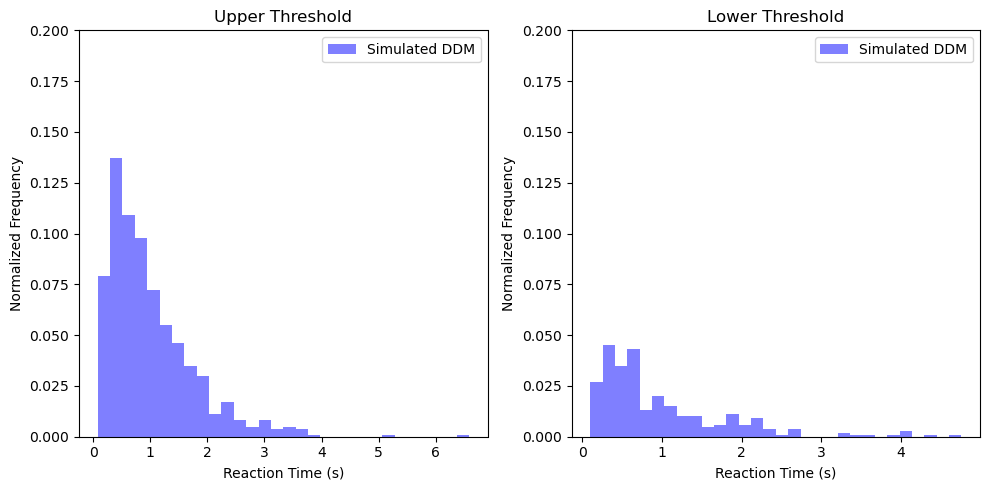

In [ ]:
# DDM parameters
v = 0.5           # drift rate
a = 2             # threshold
z = a/2           # starting point (between 0 and threshold a)
sigma = 1         # standard deviation of noise
t0 = 0            # non-decision time
dt = 0.01         # integration constant
max_time = 1000   # maximum number of simulated seconds

# Plotting parameters
y_max = 0.2       # maximum of y-axsis

# simulation
num_simulations = 1000  # number of simulated reaction times
rt_upper = []           # list used to store reaction times for upper boundary
rt_lower = []           # list used to store reaction times for lower boundary

# simulate the DDM a number of times
for sim in range(num_simulations):

  # for each simulation, retrive the decision, the evidence trace, and decision time
  decision_time, evidence_over_time, decision = run_ddm(drift_rate = v,
                                                        threshold = a,
                                                        starting_point = z,
                                                        noise_std = sigma,
                                                        non_decision_time = t0,
                                                        dt = dt,
                                                        max_time = max_time)

  # if the simulation hit the lower bound, add decision time to list of lower reaction times
  if decision == -1:
      rt_lower.append(decision_time)
  # if the simulation hit the upper bound, add decision time to list of lower upper times
  elif decision == 1:
      rt_upper.append(decision_time)

plot_ddm_histograms(rt_upper, rt_lower, y_max = y_max)

In [ ]:
dataset = filtered_df

# collect data for histogram
filtered_rt_lower = dataset[dataset['task_transition'] == 0]['rt']
rt_lower_empirical = filtered_rt_lower.to_numpy()

filtered_rt_upper = dataset[dataset['task_transition'] == 1]['rt']
rt_upper_empirical = filtered_rt_upper.to_numpy()

# print data set
dataset

,participant_id,rt,key_press,correct,coherent_movement_direction,coherent_orientation,task_type,task_transition,congruency
97,2,547,f,True,180,180,mov,0,congruent
98,2,1101,f,True,0,180,or,1,incongruent
99,2,745,f,True,180,0,mov,1,incongruent
100,2,943,f,True,180,180,or,1,congruent
101,2,814,f,True,180,180,or,0,congruent
...,...,...,...,...,...,...,...,...,...
3067,32,1401,f,True,180,0,mov,0,incongruent
3068,32,1244,j,True,0,180,mov,0,incongruent
3069,32,1246,j,True,0,0,or,1,congruent
3070,32,744,f,True,180,180,or,0,congruent


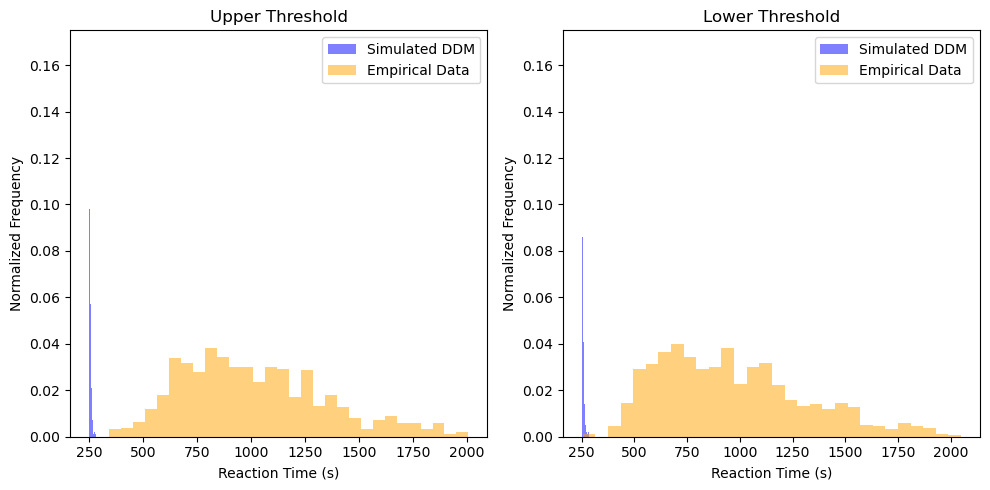

In [ ]:
# ADJUST THESE PARAMETERS FOR THE EXERCISE
v = 0.07       # drift rate
a = 5          # threshold
t0 = 250        # non-decision time

# DO NOT ADJUST THESE PARAMETERS FOR THE EXERCISE, THEY REMAIN FIXED
sigma = 1         # standard deviation of noise
dt = 0.01         # integration constant
z = a/2           # starting point (between 0 and threshold a)

# Plotting parameters
y_max = 0.175       # maximum of y-axis (you may have to adjust this)

# simulation parameters [DO NOT ADJUST]
num_simulations = 1000  # number of simulated reaction times
max_time = 1000   # maximum number of simulated seconds

rt_upper = []           # list used to store reaction times for upper boundary
rt_lower = []           # list used to store reaction times for lower boundary

# simulate the DDM a number of times
np.random.seed(0) # DO NOT REMOVE SEED
for sim in range(num_simulations):

  # for each simulation, retrive the decision, the evidence trace, and decision time
  decision_time, evidence_over_time, decision = run_ddm(drift_rate = v,
                                                        threshold = a,
                                                        starting_point = z,
                                                        noise_std = sigma,
                                                        non_decision_time = t0,
                                                        dt = dt,
                                                        max_time = max_time)

  # if the simulation hit the lower bound, add decision time to list of lower reaction times
  if decision == -1:
      rt_lower.append(decision_time)
  # if the simulation hit the upper bound, add decision time to list of lower upper times
  elif decision == 1:
      rt_upper.append(decision_time)

plot_ddm_histograms(rt_upper, rt_lower, rt_upper_empirical, rt_lower_empirical, y_max = y_max)

In [ ]:
import numpy as np
import pandas as pd

# Define parameters for the drift diffusion model
baseline_drift = 0.1
threshold = 1.0
noise_std = 0.1

# Function to simulate reaction times using drift diffusion model
def simulate_reaction_time(task_transition):
    drift_rate = baseline_drift + task_transition * 0.2  # Adjust drift rate based on task transition
    evidence_accumulator = 0
    while abs(evidence_accumulator) < threshold:
        evidence_accumulator += drift_rate + np.random.normal(0, noise_std)
    return np.random.normal(1.5, 0.2)  # Simulate variability in response times

# Apply the function to each row of the DataFrame to simulate reaction times
df['reaction_time'] = df['task_transition'].apply(simulate_reaction_time)

# Calculate mean reaction time for task switches and repetitions
mean_rt_switch = df[df['task_transition'] == 1]['reaction_time'].mean()
mean_rt_repetition = df[df['task_transition'] == 0]['reaction_time'].mean()

# Print mean reaction times
print("Mean Reaction Time for Task Switches:", mean_rt_switch)
print("Mean Reaction Time for Task Repetitions:", mean_rt_repetition)


TypeError: can't multiply sequence by non-int of type 'float'

In [ ]:
v_true, a_true, z_true, t_true = [0.5, 1.5, 0.5, 0.5]
dataset = hssm.simulate_data(
    model="ddm",
    theta=[v_true, a_true, z_true, t_true],
    size=1000,
)

dataset

,rt,response
0,2.090811,1.0
1,2.879178,1.0
2,1.955625,1.0
3,2.032836,-1.0
4,1.721658,1.0
...,...,...
995,2.452003,-1.0
996,2.834929,1.0
997,1.257440,-1.0
998,1.405637,1.0


In [ ]:
varying_drift_model = hssm.HSSM(
    data=filtered_df,
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + coherence",
        }
    ],
)

KeyError: 'response'